In [1]:
!pip install attacut
!pip install kaggle
!pip install pythainlp
!pip install pytorch-lightning
!pip install datasets
!pip install torch
!pip install wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.8/473.8 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np # linear algebra
import pandas as pd
import pandas
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
import attacut
import pythainlp
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from torch.utils.data import Dataset
from IPython.display import display
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [3]:
import os
import wandb

# Disable tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Login to wandb
wandb.login(key="65e03aafcd9e07b23dd4cf63309c4f2c353f1623")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: crimsonf09 (crimsonf09-chulalongkorn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
run = wandb.init(
    # entity="Ella",
    # # Set the wandb project where this run will be logged.
    project="Ella",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

In [5]:
type = ['Paper Work',
'Summary',
'Paraphrase',
'Simulation Role Play as a Character',
'Reasoning',
'Trending',
'Caption Generation',
'General',
'Marketing Planning']

In [6]:
def cleanData(pathCSV,filename):    
    data = []
    with open(pathCSV, "r", encoding="utf-8") as file:
        get_cols = False
        current_type = None
        current_context = None
        current_sentence = ""
    
        for line in file:
            line = line.strip()
            if not get_cols:
                cols = line.split(",")
                get_cols = True
                continue
    
            parts = line.split(",", 2)  # split into 3 parts only
    
            if len(parts) == 3:
                # Save the previous sentence before starting a new row
                if current_type is not None:
                    data.append([current_type, current_context, current_sentence.strip()])
                current_type = parts[0]
                current_context = parts[1]
                current_sentence = parts[2]
            else:
                # Continuation of sentence
                current_sentence += "\n" + line
    
        # Add the last row
        if current_type is not None:
            data.append([current_type, current_context, current_sentence.strip()])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=["type", "contextLevel", "sentence"])
    
    # Save as CSV
    df.to_csv('/kaggle/working/'+filename+'.csv', index=False)
    
    print("done " + filename)

In [7]:
cleanData('/kaggle/input/generated-data/generated_data.csv','cleaned_generated_data')
cleanData('/kaggle/input/generated-thai-dataset/generated_thai_data.csv','cleaned_generated_thai_data')

done cleaned_generated_data
done cleaned_generated_thai_data


In [8]:
eng_generated_data = pd.read_csv("/kaggle/working/cleaned_generated_data.csv")
thai_generated_data = pd.read_csv("/kaggle/working/cleaned_generated_thai_data.csv")

In [9]:
print(eng_generated_data['sentence'].isnull().sum())

0


In [10]:
print(thai_generated_data['type'].value_counts())
print(eng_generated_data['type'].value_counts())

type
Reasoning                              88
Marketing Planning                     88
General                                88
Caption Generation                     88
Trending                               88
Summary                                85
Paper Work                             83
Paraphrase                             74
Simulation Role Play as a Character    73
Name: count, dtype: int64
type
Simulation Role Play as a Character    90
General                                89
Paper Work                             88
Reasoning                              87
Summary                                87
Caption Generation                     87
Marketing Planning                     86
Paraphrase                             85
Trending                               78
Name: count, dtype: int64


In [11]:
thai_df = pd.DataFrame(thai_generated_data)
eng_df = pd.DataFrame(eng_generated_data)

In [12]:
type = ['Paper Work',
'Summary',
'Paraphrase',
'Simulation Role Play as a Character',
'Reasoning',
'Trending',
'Caption Generation',
'General',
'Marketing Planning']
type2ind={}
ind2type={}
ind = 0
for i in type:
    type2ind[i] = ind
    ind2type[ind] = i
    ind += 1
context_level = thai_df['contextLevel'].unique()
print(context_level)
context2level = {}
level2context = {}
ind = 0
for i in context_level:
    context2level[i] = ind
    level2context[ind] = i
    ind+=1

['Without Context' 'Light Context' 'Full Context']


In [13]:
thai_df['type'] = thai_df['type'].map(type2ind)
thai_df['contextLevel'] = thai_df['contextLevel'].map(context2level)
eng_df['type'] = eng_df['type'].map(type2ind)
eng_df['contextLevel'] = eng_df['contextLevel'].map(context2level)

In [14]:
# thai_df = thai_df[thai_df['type'] != 3]

In [15]:

def train_val_test_split(df):
    # First split: Train 60%, Temp 40%
    train_df, temp_df = train_test_split(
        df,
        train_size=0.6,
        random_state=99,
        stratify=df[['type', 'contextLevel']]
    )

    # Second split: Val 20%, Test 20% (half of temp)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=0.5,
        random_state=99,
        stratify=temp_df[['type', 'contextLevel']]
    )

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [16]:
thai_train_df,thai_val_df,thai_test_df = train_val_test_split(thai_df)
eng_train_df,eng_val_df,eng_test_df = train_val_test_split(eng_df)
train_df = pd.concat([thai_train_df,eng_train_df])
val_df = pd.concat([thai_val_df,eng_val_df])
test_df = pd.concat([thai_test_df,eng_test_df])
# train_df = thai_train_df
# val_df = thai_val_df
# test_df = thai_test_df

In [17]:
from difflib import SequenceMatcher

def is_similar(a, b, threshold=0.95):
    return SequenceMatcher(None, a, b).ratio() > threshold

suspicious = []
for val_sentence in val_df['sentence']:
    for train_sentence in train_df['sentence']:
        if is_similar(val_sentence, train_sentence):
            suspicious.append((val_sentence, train_sentence))
            break  # Stop early once one match is found

print(f"Found {len(suspicious)} highly similar val samples in train set")

Found 26 highly similar val samples in train set


In [18]:
train_df['type'].value_counts()

type
7    107
4    105
8    105
6    104
1    103
0    102
5    100
3     98
2     95
Name: count, dtype: int64

In [19]:
print(torch.cuda.is_available())

True


In [20]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer

checkpoint = "clicknext/phayathaibert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenizer_dataset(dataset):
    encoded = tokenizer(
        dataset['sentence'],
        padding='max_length',
        max_length=256,#128
        truncation=True,
    )
    encoded['labels'] = dataset['type']
    return encoded
train_dataset = Dataset.from_pandas(train_df[['type','sentence']])
eval_dataset = Dataset.from_pandas(val_df[['type','sentence']])

print(train_dataset[0])

# tokenize
tokenized_train_dataset = train_dataset.map(tokenizer_dataset,batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenizer_dataset,batched=True)

tokenized_train_dataset.set_format('torch')
tokenized_eval_dataset.set_format('torch')
# # dataloader
train_loader = DataLoader(tokenized_train_dataset,batch_size=32, shuffle=True)
eval_loader = DataLoader(tokenized_eval_dataset,batch_size=32, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

{'type': 5, 'sentence': 'ช่วงนี้ Facebook algorithm มีการเปลี่ยนแปลงอะไรที่นักการตลาดควรรู้?', '__index_level_0__': 0}


Map:   0%|          | 0/919 [00:00<?, ? examples/s]

Map:   0%|          | 0/306 [00:00<?, ? examples/s]

In [21]:
class HuggingFaceDataset(torch.utils.data.Dataset):
    def __init__(self,hf_dataset):
        self.dataset = hf_dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        item = self.dataset[idx]
        input_ids = item['input_ids'].clone().detach().long()
        attention_mask = item['attention_mask'].clone().detach().long()
        labels = item['labels'].clone().detach().long()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

In [22]:
train_dataset = HuggingFaceDataset(tokenized_train_dataset)
eval_dataset = HuggingFaceDataset(tokenized_eval_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [23]:
train_dataset.__getitem__(1)

{'input_ids': tensor([    5,  5960, 25299, 23608,   292, 46962, 25260, 40764,  1584,   843,
           171,    10,     3,    47,     3,     6,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [24]:
import torch
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import f1_score

class BertClassifier(pl.LightningModule):
    def __init__(self, model_name: str, num_labels: int = 9, learning_rate: float = 1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

        # Accumulators
        self.val_preds, self.val_labels = [], []
        self.test_preds, self.test_labels = [], []

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        self.val_preds.extend(preds.cpu().tolist())
        self.val_labels.extend(batch["labels"].cpu().tolist())
        self.log("val_loss", outputs.loss, prog_bar=True)
        return outputs.loss

    def on_validation_epoch_end(self):
        f1 = f1_score(self.val_labels, self.val_preds, average="micro")
        self.log("val_f1", f1, prog_bar=True)
        self.val_preds.clear()
        self.val_labels.clear()

    def test_step(self, batch, batch_idx):
        outputs = self(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        self.test_preds.extend(preds.cpu().tolist())
        self.test_labels.extend(batch["labels"].cpu().tolist())
        return outputs.loss

    def on_test_epoch_end(self):
        f1 = f1_score(self.test_labels, self.test_preds, average="micro")
        self.log("test_f1", f1)
        print(f"\n🔍 Test F1 Score (micro): {f1:.4f}")
        self.test_preds.clear()
        self.test_labels.clear()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)


In [25]:
model = BertClassifier(model_name=checkpoint, num_labels=9) 

epoch = 4
wandb_logger = WandbLogger(
    project="bert-multiclass",     # Your project name in wandb
    name="bert-run-001",           # Optional run name
    log_model="all"                # Optionally save model checkpoints to wandb
)
trainer = pl.Trainer(
    max_epochs = epoch,
    accelerator = "gpu" if torch.cuda.is_available() else "cpu",
    devices = 1,
    precision=16,   # optional
    logger=wandb_logger
)

trainer.fit(model, train_loader, val_loader)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

2025-07-08 10:06:36.292547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751969196.634761      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751969196.736567      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [26]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer

# Assuming your model and tokenizer are already defined as follows:
model_name = "clicknext/phayathaibert"  # Change this to your model's name if necessary
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize device and model (your model already has this part)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def tokenize_test_dataset(dataset):
    encoded = tokenizer(
        dataset['sentence'],
        padding='max_length',
        max_length=256,#128
        truncation=True,
    )
    return encoded

# Assuming `test_df` is your test data frame containing 'comment' column.
test_dataset = Dataset.from_pandas(test_df)

# Apply the tokenizer to the dataset
test_dataset = test_dataset.map(tokenize_test_dataset, batched=True)

# Set the format to be suitable for PyTorch (with input_ids and attention_mask)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Prepare DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set the model to evaluation mode
model.eval()

predictions = []

# Run inference
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)  # Apply softmax for multi-class classification
        
        # Get the predicted class (index of highest probability)
        preds = torch.argmax(probs, dim=-1)
        predictions.append(preds.cpu().numpy())  # Store predictions in CPU memory

# Concatenate all predictions into a single array
predicted_labels = np.concatenate(predictions, axis=0)

# Create a DataFrame to store predictions with a single column 'predicted_label'
preds_df = pd.DataFrame(predicted_labels, columns=["predicted_label"])

# Print out the predictions for the first 20 samples
for text, real_label,label in zip(test_df["sentence"],test_df['type'], predicted_labels):
    if (real_label != label):
        print(f"Text: {text}")
        print(f"True Label: {ind2type[real_label]}")
        print(f"Predicted Label: {ind2type[label]}")
        print("-" * 50)
        print("")


Map:   0%|          | 0/307 [00:00<?, ? examples/s]

Text: Generate product launch plan สำหรับสินค้าเทคโนโลยี
True Label: Paper Work
Predicted Label: Marketing Planning
--------------------------------------------------

Text: เขียน caption ใหม่สำหรับโพสต์ Facebook ที่เน้น playful tone
True Label: Paraphrase
Predicted Label: Caption Generation
--------------------------------------------------

Text: Create a project timeline สำหรับ digital campaign
True Label: Paper Work
Predicted Label: Marketing Planning
--------------------------------------------------

Text: Our e-commerce brand wants to use more video. Any creative formats?
True Label: General
Predicted Label: Reasoning
--------------------------------------------------

Text: We want to try a viral dance challenge. Which one is best for our brand?
True Label: Trending
Predicted Label: General
--------------------------------------------------

Text: Which emojis are brands using most in captions?
True Label: Trending
Predicted Label: Reasoning
------------------------------------

In [27]:
predicted_labels

array([6, 0, 5, 6, 4, 3, 8, 2, 8, 0, 2, 2, 8, 1, 4, 3, 6, 4, 1, 8, 0, 8,
       8, 3, 1, 4, 4, 2, 1, 4, 3, 0, 2, 3, 0, 4, 4, 4, 5, 0, 1, 1, 3, 8,
       8, 4, 1, 5, 6, 6, 6, 3, 6, 1, 4, 6, 5, 5, 4, 1, 8, 6, 0, 6, 4, 5,
       1, 2, 1, 8, 5, 7, 7, 0, 7, 1, 0, 4, 0, 2, 5, 4, 8, 7, 0, 6, 7, 3,
       6, 8, 2, 1, 0, 8, 1, 0, 7, 6, 1, 3, 5, 7, 0, 2, 2, 4, 5, 8, 2, 7,
       8, 2, 5, 6, 6, 8, 7, 0, 7, 3, 6, 4, 5, 3, 7, 1, 7, 7, 6, 2, 3, 4,
       5, 3, 2, 8, 1, 3, 3, 7, 5, 7, 5, 6, 8, 7, 8, 8, 5, 7, 5, 7, 4, 1,
       8, 7, 0, 3, 1, 3, 1, 6, 4, 6, 2, 0, 7, 2, 7, 2, 1, 0, 1, 4, 3, 8,
       5, 4, 0, 5, 8, 3, 3, 8, 1, 3, 1, 4, 3, 6, 6, 5, 6, 2, 8, 1, 2, 2,
       4, 0, 7, 2, 7, 3, 7, 2, 2, 2, 6, 8, 2, 3, 0, 1, 5, 6, 6, 7, 6, 5,
       3, 1, 8, 8, 8, 4, 4, 0, 6, 0, 7, 6, 3, 5, 4, 0, 4, 4, 3, 3, 6, 2,
       8, 3, 2, 4, 4, 0, 4, 3, 4, 7, 8, 5, 3, 6, 4, 8, 0, 0, 6, 0, 8, 8,
       1, 4, 2, 1, 7, 7, 2, 3, 7, 1, 6, 1, 7, 5, 6, 0, 0, 6, 4, 0, 5, 7,
       5, 4, 5, 4, 0, 2, 1, 7, 3, 7, 6, 4, 1, 1, 8,

Accuracy: 0.9707
F1 Scores:
  Micro:    0.9707
  Macro:    0.9712
  Weighted: 0.9708

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       1.00      1.00      1.00        35
           2       1.00      0.97      0.98        32
           3       1.00      1.00      1.00        33
           4       0.90      0.97      0.93        36
           5       1.00      0.94      0.97        32
           6       0.97      1.00      0.99        35
           7       0.94      0.91      0.93        35
           8       0.94      1.00      0.97        34

    accuracy                           0.97       307
   macro avg       0.97      0.97      0.97       307
weighted avg       0.97      0.97      0.97       307



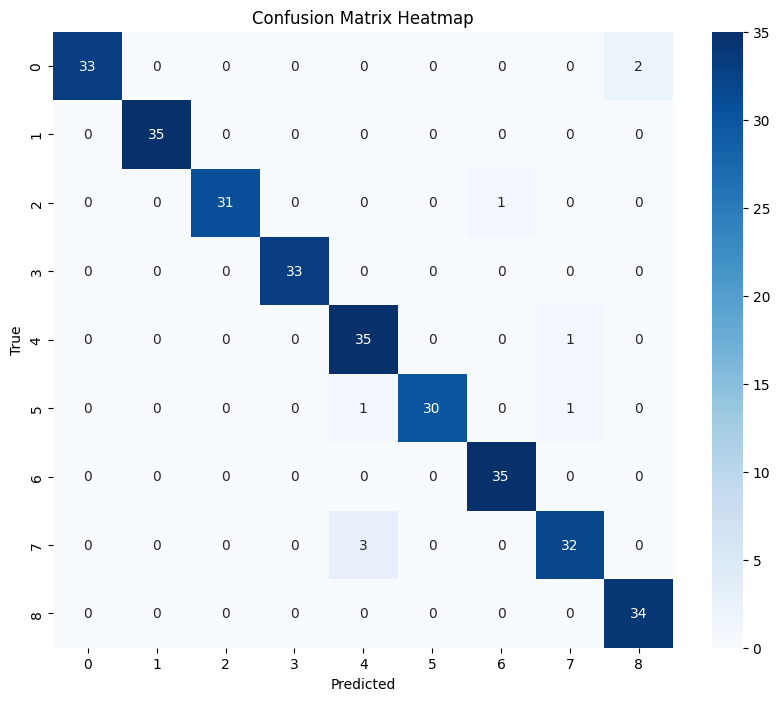

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Assuming these are already defined
# test_df = pd.DataFrame({'type': [...your true labels...]})
# predicted_labels = [...your predicted labels...]

# Convert to NumPy arrays (if needed)
true_labels = np.array(test_df['type'])
preds = np.array(predicted_labels)

# Accuracy
acc = accuracy_score(true_labels, preds)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro, micro, weighted)
print("F1 Scores:")
print(f"  Micro:    {f1_score(true_labels, preds, average='micro'):.4f}")
print(f"  Macro:    {f1_score(true_labels, preds, average='macro'):.4f}")
print(f"  Weighted: {f1_score(true_labels, preds, average='weighted'):.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, preds))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
labels = sorted(np.unique(np.concatenate([true_labels, preds])))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [29]:
type2ind

{'Paper Work': 0,
 'Summary': 1,
 'Paraphrase': 2,
 'Simulation Role Play as a Character': 3,
 'Reasoning': 4,
 'Trending': 5,
 'Caption Generation': 6,
 'General': 7,
 'Marketing Planning': 8}

In [30]:
trainer.save_checkpoint("bert_multiclass_new.ckpt")

In [34]:
import shutil

# Compress the .ckpt file into a zip for safe download
shutil.make_archive("/kaggle/working/", 'zip', "/kaggle/working", "/kaggle/working/bert_multiclass_new.ckpt")


KeyboardInterrupt: 

In [33]:
import shutil

shutil.make_archive('zipped_file_name', 'zip', '/kaggle/working/bert_multiclass_new.ckpt')

NotADirectoryError: [Errno 20] Not a directory: '/kaggle/working/bert_multiclass_new.ckpt'